<a href="https://colab.research.google.com/github/Annie00000/Project/blob/main/1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import time
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import Sequence



## Load data

In [5]:
# 記錄開始時間
start_time = time.time()

# 讀取所有影像路徑和標籤
data_dir = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/train/'
image_paths = []
labels = []

for class_folder in os.listdir(data_dir):
    class_folder_path = os.path.join(data_dir, class_folder)
    for file in os.listdir(class_folder_path):
        fpath = os.path.join(class_folder_path, file)
        image_paths.append(fpath)
        labels.append(class_folder)

# 計算讀取時間
data_loading_time = time.time() - start_time
print(f"Data loading time: {data_loading_time} seconds")

Data loading time: 11.964333534240723 seconds


### 查看每个类别的比例

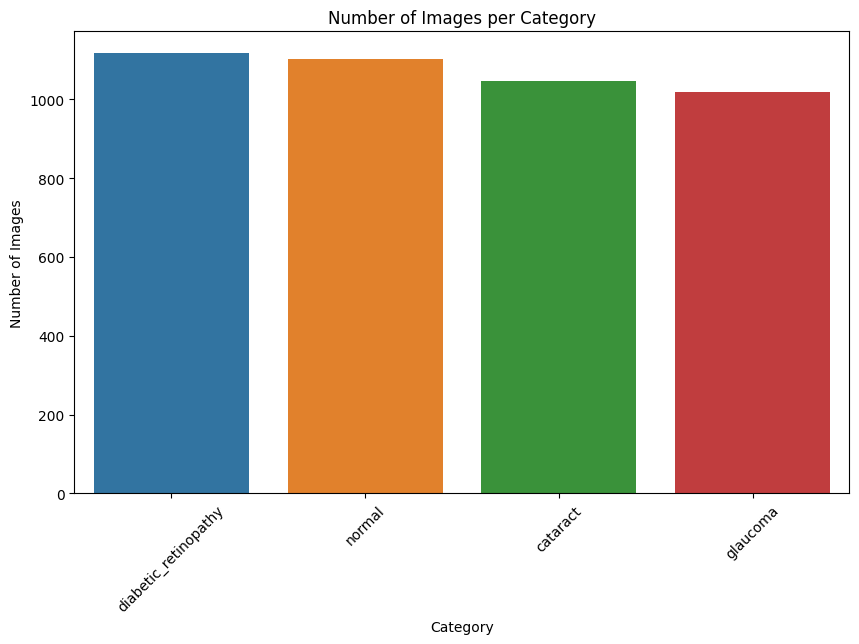

In [6]:
# 创建DataFrame
label_df = pd.DataFrame({'Label': labels, 'Image_Path': image_paths})

# 计算每个类别的图像数量
label_counts = label_df['Label'].value_counts()

# 可视化类别比例
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [7]:
# 文字表示每个类别的比例
for label, count in label_counts.items():
    print(f"Category '{label}':  {count} images, accounting for {round(100 * count/len(label_df),2)}% of all. ")

Category 'diabetic_retinopathy':  1117 images, accounting for 26.07% of all. 
Category 'normal':  1102 images, accounting for 25.72% of all. 
Category 'cataract':  1048 images, accounting for 24.46% of all. 
Category 'glaucoma':  1018 images, accounting for 23.76% of all. 


### 可视化每个类别各一张图片

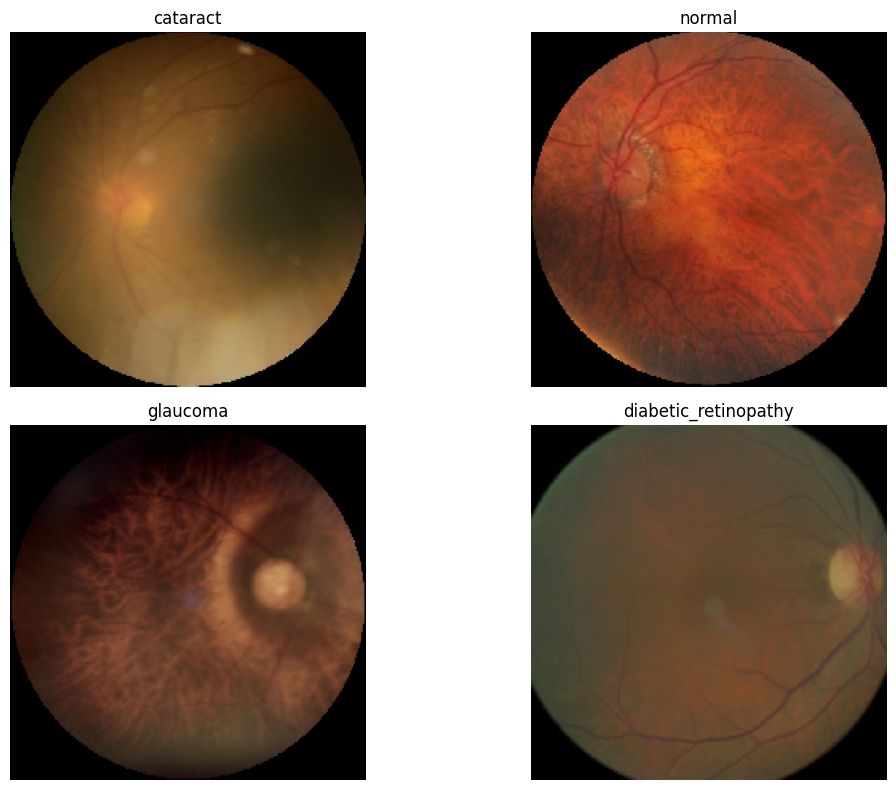

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# 可视化每个类别的随机一张图片
unique_labels = label_df['Label'].unique()
plt.figure(figsize=(12, 8))

for i, label in enumerate(unique_labels):
    label_images = label_df[label_df['Label'] == label]['Image_Path'].tolist()
    random_image_path = random.choice(label_images)
    img = load_img(random_image_path, target_size=(224, 224))  # 调整为所需的尺寸

    plt.subplot(2, 2, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

### 切分訓練集/驗證集/測試集

In [8]:
# 切分訓練集、驗證集和測試集
train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, stratify=labels ,shuffle=True, random_state=42)
#val_paths, test_paths, val_labels, test_labels = train_test_split(test_val_paths, test_val_labels, test_size=0.5, stratify=test_val_labels,shuffle=True, random_state=42)

In [9]:
# 将标签转换为数字
unique_labels = sorted(set(labels))
label_to_index = {label: index for index, label in enumerate(unique_labels)}
#indices = [label_to_index[label] for label in labels]

# 建立標籤查詢的DataFrame
label_to_index_df = pd.DataFrame(list(label_to_index.items()), columns=['Label', 'Index'])

## Data augmentation (自定義數據增強)

In [10]:
# 載入CSV檔案來獲取增強設置
augmentation_csv_path = '/content/drive/MyDrive/Colab Notebooks/eye_diseases/augmentation.csv'
augmentation_df = pd.read_csv(augmentation_csv_path)

# 創建一個字典來儲存每個類別的增強設置
augmentation_dict = {row['label']: row.drop('label').to_dict() for _, row in augmentation_df.iterrows()}
#augmentation_dict = {label_to_index[row['label']]: row.drop('label').to_dict() for _, row in augmentation_df.iterrows()}

### 使用自定義數據生成器

## 1. 使用GPU 的方式來執行數據增強(tensor)

##### 第一種: 直接在 TensorFlow 中載入和解碼映像。這意味著從一開始圖像就是以 Tensor 的形式存在的

* (補充)  加入 CLAHE(自適應值方圖均衡化) 數據增強

In [69]:
import cv2


class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True, apply_clahe=False):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.apply_clahe_flag = apply_clahe
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            # 加载和预处理图像 (直接在 TensorFlow 中載入和解碼映像。這意味著從一開始圖像就是以 Tensor 的形式存在的)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            # 应用数据增强
            img = self.apply_augmentation(img, label)  # 規一化
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        # 根据标志决定是否应用CLAHE
        if self.apply_clahe_flag:
            image = self.apply_clahe(image)

        return image

    def apply_clahe(self,image):
        # 将 Tensor 转换为 NumPy 数组
        image_np = image.numpy().astype(np.uint8)


        # 转换图像到灰度（如果是彩色图像）
        if image_np.shape[-1] == 3:
            img_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
        else:
            img_gray = image_np

        # 创建CLAHE对象
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        # 应用CLAHE
        clahe_img = clahe.apply(img_gray)

        # 如果需要，将处理后的图像转换回彩色
        if image.shape[-1] == 3:
            clahe_img = cv2.cvtColor(clahe_img, cv2.COLOR_GRAY2RGB)


        # 将 NumPy 数组转换回 Tensor
        return tf.convert_to_tensor(clahe_img, dtype=tf.float32)


    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)



* CLAHE 参数解释

  1. 对比度限制值 (clipLimit): 这个参数控制图像的对比度增强程度。较低的值意味着更轻微的增强，较高的值将更显著地增强对比度。常见的取值范围在 1 到 3 之间。

  2. 网格大小 (tileGridSize): 这个参数定义了应用直方图均衡化的小区块的大小。较小的网格将对细节进行更精细的调整，但可能会导致噪声的增加；较大的网格则相对较粗糙但更平滑。常用的网格大小包括 (8, 8)、(16, 16) 等。

* 由於上面方式在查看數據增量的圖片的時候，發現是灰色圖，可以考慮改用下面方法。

在应用 CLAHE 之前保留原始的彩色图像，并在应用完 CLAHE 后，将处理过的灰度图像与原始彩色图像的颜色通道结合。但是，这种方法在保持原始颜色方面可能并不完美，因为 CLAHE 主要用于增强图像的局部对比度，而不是用于保留或恢复颜色信息。

- 尝试只对彩色图像的亮度通道应用 CLAHE，而保持颜色通道不变。这通常涉及将图像从 RGB 转换到 YCrCb 颜色空间，对 Y（亮度）通道应用 CLAHE，然后再转换回 RGB 空间。以下是修改后的方法：

- 注意 : 这种方法更适合于保持原始图像的颜色，同时增强局部对比度。

  请记住，CLAHE 主要用于增强图像的局部细节，它可能不总是保留颜色信息，特别是在高对比度的区域。

In [74]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True, apply_clahe=False):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.apply_clahe_flag = apply_clahe
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            # 加载和预处理图像 (直接在 TensorFlow 中載入和解碼映像。這意味著從一開始圖像就是以 Tensor 的形式存在的)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            # 应用数据增强
            img = self.apply_augmentation(img, label)/255  # 規一化
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        # 根据标志决定是否应用CLAHE
        if self.apply_clahe_flag:
            image = self.apply_clahe(image)

        return image

    def apply_clahe(self,image):
        # 将 Tensor 转换为 NumPy 数组
        image_np = image.numpy().astype(np.uint8)

        # 转换图像到 YCrCb 颜色空间
        image_ycrcb = cv2.cvtColor(image_np, cv2.COLOR_RGB2YCrCb)

        # 单独对亮度通道应用CLAHE
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        image_ycrcb[:, :, 0] = clahe.apply(image_ycrcb[:, :, 0])

        # 将处理后的图像转换回RGB颜色空间
        image_rgb = cv2.cvtColor(image_ycrcb, cv2.COLOR_YCrCb2RGB)

        # 将 NumPy 数组转换回 Tensor
        return tf.convert_to_tensor(image_rgb, dtype=tf.float32)


    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)



In [75]:
# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), shuffle=True, apply_clahe=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), shuffle=False, apply_clahe=False
)

#### 不使用augmentation_dict,固定做隨機旋轉10度

In [ ]:
from scipy.ndimage import rotate

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, label_to_index, num_classes, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        #self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            # 加载和预处理图像 (直接在 TensorFlow 中載入和解碼映像。這意味著從一開始圖像就是以 Tensor 的形式存在的)
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            # 应用数据增强
            img = self.apply_augmentation(img, label)/ 255 # 規一化
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image):
        # 随机旋转（正负 10 度）
        rotation_degree = random.uniform(-10, 10)
        image = rotate(image, rotation_degree, reshape=False, mode='nearest')

        # 对比度增强
        contrast_factor = 1.5  # 可以根据需要调整这个值
        image = self.adjust_contrast(image, contrast_factor)

        return image

    def adjust_contrast(self, image, contrast_factor):
        """调整图像的对比度"""
        mean = np.mean(image, axis=(0, 1), keepdims=True)
        adjusted = (image - mean) * contrast_factor + mean
        return np.clip(adjusted, 0, 255)


    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)



# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
     label_to_index=label_to_index,
    num_classes=len(unique_labels), shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    label_to_index=label_to_index,
    num_classes=len(unique_labels), shuffle=False
)

##### 第二種

在下面這个生成器中，我们首先将每个图像加载为 NumPy 数组，然后使用 tf.convert_to_tensor 将其转换为 TensorFlow Tensor。之后，我们将这个 Tensor 传递给 apply_augmentation 函数进行增强。最后，我们将整个批次的图像和标签列表转换为 TensorFlow Tensor，以便与 TensorFlow 模型兼容。

请注意，这种方法将在内存中保留整个批次的图像数据，所以如果您处理的图像数据量非常大，可能需要调整批次大小以避免内存不足的问题。此外，由于 apply_augmentation 现在接受的是 Tensor，确保所有的图像处理操作都是在 TensorFlow 的图操作中完成的。

In [ ]:

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            # 使用 Keras 的 load_img 和 img_to_array 載入映像，隨後將其轉換為 TensorFlow Tensor。
            # 這表示載入和初步處理步驟在 CPU 上完成，然後轉移到 TensorFlow 圖中。
            img = load_img(img_path, target_size=self.target_size) # 使用 load_img 通常更適合處理 JPEG 格式的圖像。儘管它也可以處理 PNG 格式，但可能需要額外的轉換步驟（例如處理透明度通道)
            img = img_to_array(img)
            img = tf.convert_to_tensor(img)  # 将图像转换为Tensor
            img = self.apply_augmentation(img, label, self.augmentation_dict)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])  # Convert label to index

        # 转换为TensorFlow Tensor格式
        batch_images = tf.convert_to_tensor(batch_images)
        batch_labels = tf.convert_to_tensor(batch_labels)

        return batch_images, to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(image, label, augmentation_dict):
        settings = augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if  settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image


    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)



###### Tensor + 數據增強 + 不平衡數據集處理(oversampling)

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, oversample=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.oversample = oversample
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img = tf.convert_to_tensor(img)  # 将图像转换为Tensor
            img = self.apply_augmentation(img, label, self.augmentation_dict)  # 使用 TensorFlow 图像操作
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image


    def on_epoch_end(self):
        if self.oversample:
            max_size = max([sum(self.labels == label) for label in np.unique(self.labels)])
            self.image_paths, self.labels = self.__oversample_data(max_size)

        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __oversample_data(self, max_size):
        new_image_paths = []
        new_labels = []
        for label in np.unique(self.labels):
            label_indices = np.where(self.labels == label)[0]
            upsample_indices = np.random.choice(label_indices, size=max_size, replace=True)
            new_image_paths.extend(self.image_paths[upsample_indices])
            new_labels.extend(self.labels[upsample_indices])
        return np.array(new_image_paths), np.array(new_labels)



In [ ]:
# 创建模型
model = Sequential([
    DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min')
]

# 训练模型，使用过采样和数据增强
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)

history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

4. 使用GPU 的方式來執行數據增強(tensor)  (有oversampling)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import class_weight
import random

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, oversample=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.oversample = oversample
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]

            # 加载和预处理图像
            img = tf.io.read_file(img_path)
            img = tf.image.decode_image(img, channels=3)
            img = tf.image.resize(img, self.target_size)

            # 应用数据增强
            img = self.apply_augmentation(img, label)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.oversample:
            self.image_paths, self.labels = self.__oversample_data()
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __oversample_data(self):
        max_size = max([sum(self.labels == label) for label in np.unique(self.labels)])
        new_image_paths = []
        new_labels = []
        for label in np.unique(self.labels):
            label_indices = np.where(self.labels == label)[0]
            upsample_indices = np.random.choice(label_indices, size=max_size, replace=True)
            new_image_paths.extend(self.image_paths[upsample_indices])
            new_labels.extend(self.labels[upsample_indices])
        return np.array(new_image_paths), np.array(new_labels)

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 假设您已经定义了下面的变量
# train_paths, train_labels, val_paths, val_labels, augmentation_dict, label_to_index, unique_labels

# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)


#### 创建数据生成器实例

In [ ]:
# 假设 label_to_index 和 num_classes 已经定义
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224), augmentation_dict=augmentation_dict,
    label_to_index=label_to_index, num_classes=len(unique_labels), shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224), augmentation_dict={},
    label_to_index=label_to_index, num_classes=len(unique_labels), shuffle=False
)

In [ ]:
# 创建数据生成器实例
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)



### 展示数据增强的样本 (批次)

图像数据类型: <dtype: 'float32'>
图像最小值: 0.007843138
图像最大值: 1.0
图像数据类型: <dtype: 'float32'>
图像最小值: 0.0
图像最大值: 1.0
图像数据类型: <dtype: 'float32'>
图像最小值: 0.007843138
图像最大值: 1.0
图像数据类型: <dtype: 'float32'>
图像最小值: 0.007843138
图像最大值: 0.98039216
图像数据类型: <dtype: 'float32'>
图像最小值: 0.003921569
图像最大值: 1.0
图像数据类型: <dtype: 'float32'>
图像最小值: 0.0
图像最大值: 1.0
图像数据类型: <dtype: 'float32'>
图像最小值: 0.011764706
图像最大值: 1.0
图像数据类型: <dtype: 'float32'>
图像最小值: 0.0
图像最大值: 1.0


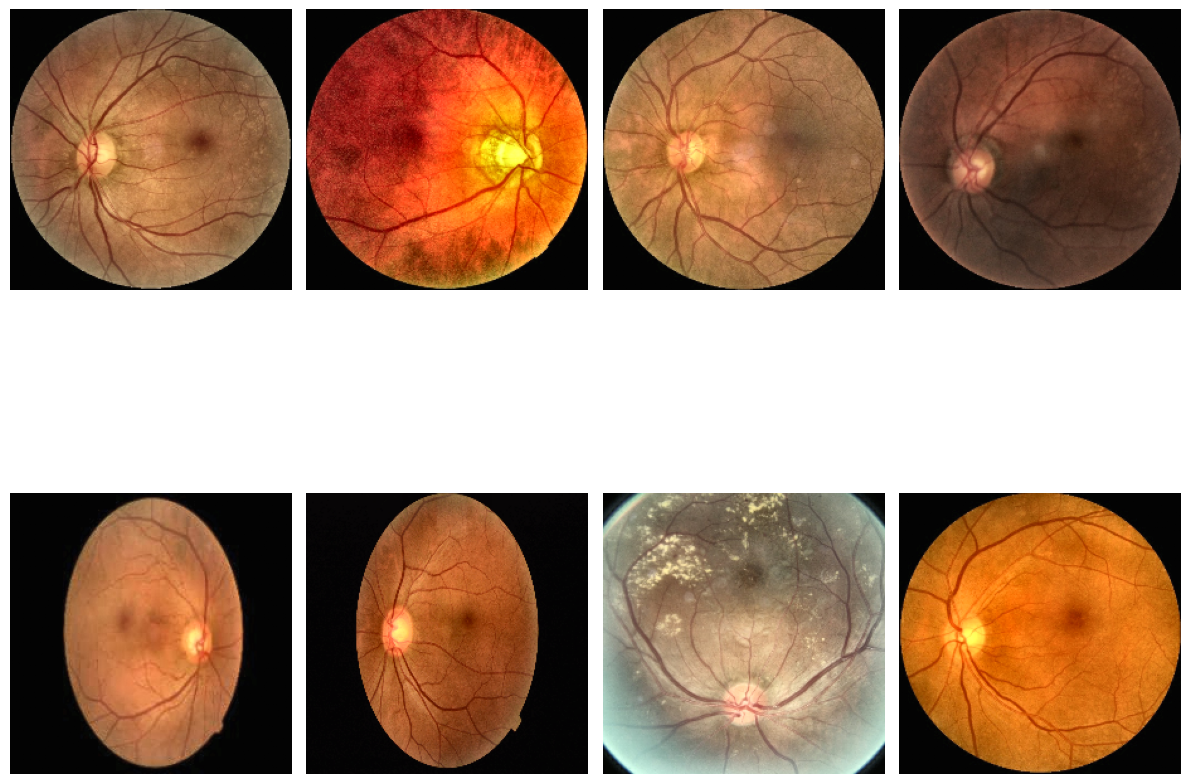

In [76]:
import matplotlib.pyplot as plt


# 将数据生成器转换为迭代器
train_generator_iter = iter(train_generator)

# 从数据生成器中获取一个批次的数据
batch_images, batch_labels = next(train_generator_iter)


# 设置要展示的图片数量
num_images_to_show = 8

# 确保不超过批次大小
num_images_to_show = min(num_images_to_show, batch_images.shape[0])

plt.figure(figsize=(12, 12))

for i in range(num_images_to_show):
    plt.subplot(2, num_images_to_show // 2, i + 1)
    # train_generator 生成的图像已经被归一化，所以需要调整回 0-255 范围
    img = batch_images[i]

    plt.imshow(img)
    plt.axis('off')

plt.tight_layout()
plt.show()

## Model

In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from keras.applications import Xception
from tensorflow.keras.callbacks import Callback

# 創建DenseNet模型
model = Sequential([
    Xception(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(len(unique_labels), activation='softmax')
])

# 編譯模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 設定回調
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1)
model_checkpoint = ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min') # 可改成.keras格式('model_best.keras')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001, verbose=1)


callbacks = [early_stopping, model_checkpoint , reduce_lr]



In [23]:
import tensorflow as tf
# 記得開啟GPU訓練-變更執行階段類型
tf.config.list_physical_devices('GPU')


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [35]:
# 開始訓練
training_start_time = time.time()

# 訓練
epochs=10
history = model.fit(
    train_generator(),
    steps_per_epoch=len(train_paths) // batch_size,
    validation_data=val_generator(),
    validation_steps=len(val_paths) // batch_size,
    epochs=epochs,
    callbacks=callbacks
)



training_duration = time.time() - training_start_time
print(f"Total training time: {training_duration} seconds")



'''
## 可以考慮 調整類別權重來 改善 資料不平衡
from sklearn.utils.class_weight import compute_class_weight

# 计算类别权重
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = {label_to_index[label]: weight for label, weight in zip(np.unique(train_labels), class_weights)}
# 上面可用class_weights = dict(enumerate(class_weights))


# 在模型训练时使用类别权重
history = model.fit(train_generator, validation_data=val_generator, epochs=10, class_weight=class_weights)
'''

'''
## 補充 : Focal loss
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        pt = tf.where(tf.equal(y_true, 1), y_pred, 1 - y_pred)
        return -tf.reduce_sum(alpha * tf.pow(1. - pt, gamma) * tf.log(pt))
    return focal_loss_fixed

# 使用自定义的焦点损失函数
model.compile(optimizer='adam', loss=focal_loss(gamma=2., alpha=0.25), metrics=['accuracy'])
'''

Epoch 1/10
108/108 [==============================] - ETA: 0s - loss: 0.5309 - accuracy: 0.8075 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


108/108 [==============================] - 2038s 19s/step - loss: 0.5309 - accuracy: 0.8075 - val_loss: 1.7164 - val_accuracy: 0.6838 - lr: 0.0010
Epoch 2/10
108/108 [==============================] - 113s 1s/step - loss: 0.3283 - accuracy: 0.8909 - val_loss: 6.2483 - val_accuracy: 0.5753 - lr: 0.0010
Epoch 3/10
108/108 [==============================] - 114s 1s/step - loss: 0.2633 - accuracy: 0.9137 - val_loss: 0.5452 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 4/10
108/108 [==============================] - 112s 1s/step - loss: 0.2487 - accuracy: 0.9221 - val_loss: 0.6479 - val_accuracy: 0.8121 - lr: 0.0010
Epoch 5/10
108/108 [==============================] - 114s 1s/step - loss: 0.2004 - accuracy: 0.9326 - val_loss: 0.9729 - val_accuracy: 0.7981 - lr: 0.0010
Epoch 6/10
108/108 [==============================] - 114s 1s/step - loss: 0.1952 - accuracy: 0.9376 - val_loss: 1.5098 - val_accuracy: 0.7386 - lr: 0.0010
Epoch 7/10
108/108 [==============================] - 122s 1s/step - loss

### 查看訓練結果

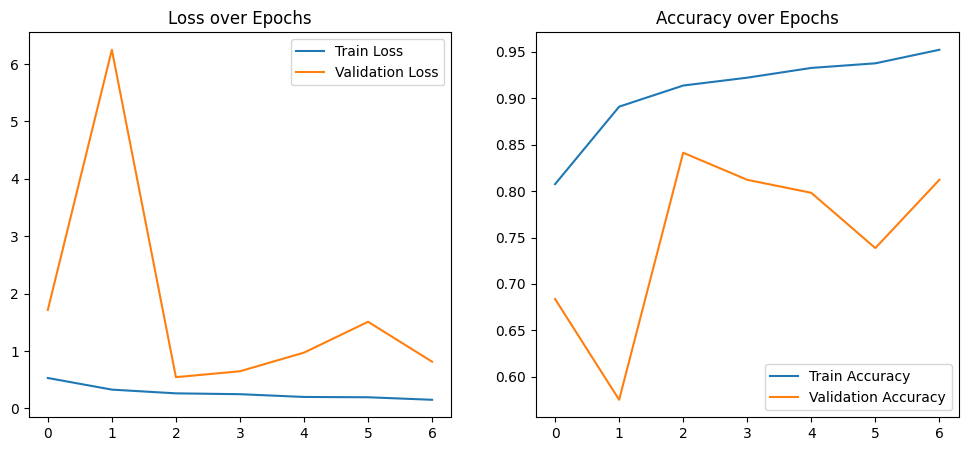

In [58]:
# 绘制训练和验证过程中的损失和准确率
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 绘制损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.legend()

# 绘制准确率
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show()

#### Tensor版

在下面這个生成器中，我们首先将每个图像加载为 NumPy 数组，然后使用 tf.convert_to_tensor 将其转换为 TensorFlow Tensor。之后，我们将这个 Tensor 传递给 apply_augmentation 函数进行增强。最后，我们将整个批次的图像和标签列表转换为 TensorFlow Tensor，以便与 TensorFlow 模型兼容。

请注意，这种方法将在内存中保留整个批次的图像数据，所以如果您处理的图像数据量非常大，可能需要调整批次大小以避免内存不足的问题。此外，由于 apply_augmentation 现在接受的是 Tensor，确保所有的图像处理操作都是在 TensorFlow 的图操作中完成的。

In [ ]:

class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, shuffle=True):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            # 使用 Keras 的 load_img 和 img_to_array 載入映像，隨後將其轉換為 TensorFlow Tensor。
            # 這表示載入和初步處理步驟在 CPU 上完成，然後轉移到 TensorFlow 圖中。
            img = load_img(img_path, target_size=self.target_size) # 使用 load_img 通常更適合處理 JPEG 格式的圖像。儘管它也可以處理 PNG 格式，但可能需要額外的轉換步驟（例如處理透明度通道)
            img = img_to_array(img)
            img = tf.convert_to_tensor(img)  # 将图像转换为Tensor
            img = self.apply_augmentation(img, label, self.augmentation_dict)
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])  # Convert label to index

        # 转换为TensorFlow Tensor格式
        batch_images = tf.convert_to_tensor(batch_images)
        batch_labels = tf.convert_to_tensor(batch_labels)

        return batch_images, to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(image, label, augmentation_dict):
        settings = augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if  settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image


    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)



##### Tensor + 數據增強 + 不平衡數據集處理(oversampling)

In [ ]:
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, target_size, augmentation_dict, label_to_index, num_classes, oversample=False, shuffle=True):
        self.image_paths = np.array(image_paths)
        self.labels = np.array(labels)
        self.batch_size = batch_size
        self.target_size = target_size
        self.augmentation_dict = augmentation_dict
        self.label_to_index = label_to_index
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.oversample = oversample
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = []
        batch_labels = []

        for i in batch_indices:
            img_path = self.image_paths[i]
            label = self.labels[i]
            img = load_img(img_path, target_size=self.target_size)
            img = img_to_array(img)
            img = tf.convert_to_tensor(img)  # 将图像转换为Tensor
            img = self.apply_augmentation(img, label, self.augmentation_dict)  # 使用 TensorFlow 图像操作
            batch_images.append(img)
            batch_labels.append(self.label_to_index[label])

        return tf.convert_to_tensor(batch_images), to_categorical(batch_labels, num_classes=self.num_classes)

    def apply_augmentation(self, image, label):
        settings = self.augmentation_dict.get(label, {})

        # 旋转
        if all([settings.get('rotate 90'), settings.get('rotate 180'), settings.get('rotate 270')]):
            angle = random.choice([90, 180, 270])
            image = tf.image.rot90(image, k=angle // 90)
        elif settings.get('rotate 180'):
            image = tf.image.rot90(image, k=2)

        # 翻转
        if settings.get('水平翻轉'):
            image = tf.image.random_flip_left_right(image)
        if settings.get('垂直翻轉'):
            image = tf.image.random_flip_up_down(image)

        return image


    def on_epoch_end(self):
        if self.oversample:
            max_size = max([sum(self.labels == label) for label in np.unique(self.labels)])
            self.image_paths, self.labels = self.__oversample_data(max_size)

        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __oversample_data(self, max_size):
        new_image_paths = []
        new_labels = []
        for label in np.unique(self.labels):
            label_indices = np.where(self.labels == label)[0]
            upsample_indices = np.random.choice(label_indices, size=max_size, replace=True)
            new_image_paths.extend(self.image_paths[upsample_indices])
            new_labels.extend(self.labels[upsample_indices])
        return np.array(new_image_paths), np.array(new_labels)



In [ ]:
# 创建模型
model = Sequential([
    DenseNet121(include_top=False, input_shape=(224, 224, 3), weights='imagenet'),
    Flatten(),
    Dense(len(unique_labels), activation='softmax')
])

# 编译模型
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# 回调函数
callbacks = [
    EarlyStopping(monitor='val_loss', patience=4, verbose=1),
    ModelCheckpoint('model_best.h5', save_best_only=True, monitor='val_loss', mode='min')
]

# 训练模型，使用过采样和数据增强
train_generator = CustomDataGenerator(
    train_paths, train_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict=augmentation_dict, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=True, shuffle=True
)
val_generator = CustomDataGenerator(
    val_paths, val_labels, batch_size=32, target_size=(224, 224),
    augmentation_dict={}, label_to_index=label_to_index,
    num_classes=len(unique_labels), oversample=False, shuffle=False
)

history = model.fit(train_generator, epochs=10, validation_data=val_generator, callbacks=callbacks)

## 測試集檢驗

In [ ]:
# 定义测试数据的路径
test_data_dir = '/path/to/your/test/data/'

# 读取所有测试图像的路径和标签
test_image_paths = []
test_labels = []

for class_folder in os.listdir(test_data_dir):
    class_folder_path = os.path.join(test_data_dir, class_folder)
    for file in os.listdir(class_folder_path):
        fpath = os.path.join(class_folder_path, file)
        test_image_paths.append(fpath)
        test_labels.append(class_folder)

# 创建测试集的数据生成器
test_generator = CustomDataGenerator(
    test_image_paths, test_labels, batch_size=32, target_size=(224, 224), augmentation_dict={},
    label_to_index=label_to_index, num_classes=len(unique_labels), shuffle=False)

In [ ]:
# 开始计时
test_start_time = time.time()

# 对测试集进行评估
test_loss, test_accuracy = model.evaluate(test_generator)

# 记录运行时间
test_duration = time.time() - test_start_time
print(f"Test Evaluation Time: {test_duration} seconds")

# 打印结果
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

### 繪製confusion table

27/27 [==============================] - 13s 471ms/step


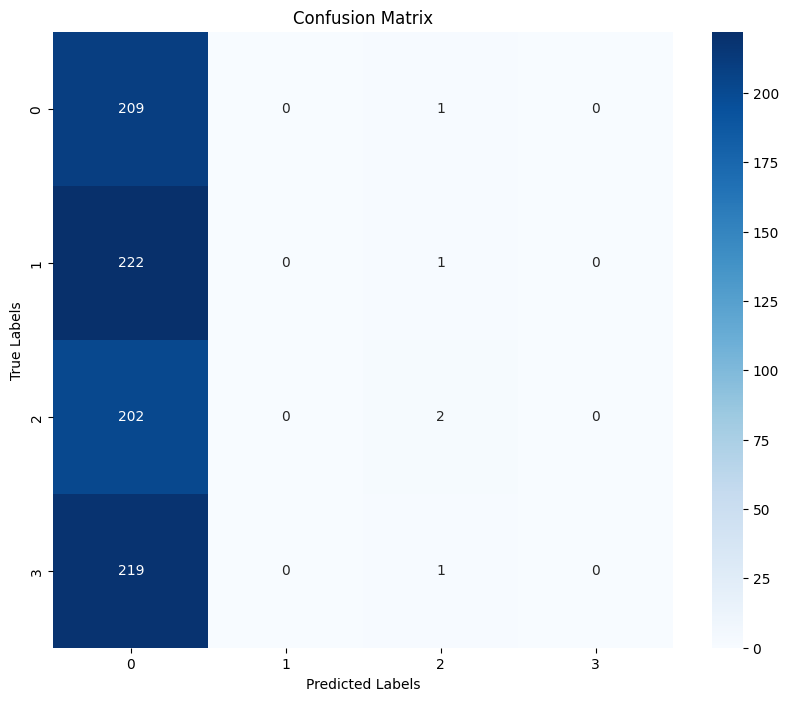

In [72]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# 获取测试集上的预测结果
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 将测试集的真实标签转换为索引
true_classes = np.array([label_to_index[label] for label in val_labels])

# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 如果測試集資料很大

如果测试集很大，导致一次性使用 model.predict 函数时内存不足，您可以通过逐批处理测试集数据并"分批"收集预测结果来解决这个问题。以下是分批预测并计算混淆矩阵的步骤：


1. 初始化：创建两个空列表，一个用于存储预测类别，另一个用于存储真实类别。
2. 逐批预测：遍历测试数据生成器的每一个批次，使用模型进行预测，并将预测结果与真实标签存储起来。

In [ ]:
total_loss = 0.0
total_accuracy = 0.0
num_batches = 0

for batch_images, batch_labels in test_generator:
    loss, accuracy = model.evaluate(batch_images, batch_labels, verbose=0)
    total_loss += loss
    total_accuracy += accuracy
    num_batches += 1

# 计算平均损失值和准确率
average_loss = total_loss / num_batches
average_accuracy = total_accuracy / num_batches

print(f"Test Loss: {average_loss}")
print(f"Test Accuracy: {average_accuracy}")

In [ ]:
predicted_classes = []
true_classes = []

for i in range(len(test_generator)):
    batch_images, batch_labels = test_generator[i]
    batch_predictions = model.predict(batch_images)
    batch_predicted_classes = np.argmax(batch_predictions, axis=1)

    predicted_classes.extend(batch_predicted_classes)
    true_classes.extend(np.argmax(batch_labels, axis=1))

# 确保预测结果和真实标签是 NumPy 数组
predicted_classes = np.array(predicted_classes)
true_classes = np.array(true_classes)

In [ ]:
# 计算混淆矩阵
cm = confusion_matrix(true_classes, predicted_classes)

# 绘制混淆矩阵
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

注意事项 :

确保在遍历生成器时不要改变其状态（例如，不要重新洗牌）。

如果您的模型在编译时设置了 metrics=['accuracy']，则还可以在每个批次中计算精度，并最后平均这些精度值以获得整体精度。

### 查看特定類別中，被错误分类的案例 (真實為A類，卻沒有被正確預估回A類的那些案例的數量，大於0才展示)

In [ ]:
# 获取所有类别名称
class_labels = list(label_to_index.keys()) # 可用 :class_labels = os.listdir(data_dir) / labels (原本讀入資料就有建造的)


# 对每个类别进行检查
for i, label in enumerate(class_labels):
    total_cases = cm[i, :].sum()  # 该类别的总案例数
    incorrect_predictions = total_cases - cm[i, i]  # 错误预测的案例数
    if incorrect_predictions > 0:
        incorrect_percentage = (incorrect_predictions / total_cases) * 100  # 计算错误分类的比例
        print(f"真实为 '{label}' 类，但未正确预测的案例数量: {incorrect_predictions} (该类别总数: {total_cases}, 比例: {incorrect_percentage:.2f}%)")

#  cm[i, j] 表示真实标签为类别 i 但被预测为类别 j 的数量
# 对于每个类别 i，我们计算了除了正确分类 (cm[i, i]) 之外的所有预测的总和，这表示被错误分类的案例数量。

### 查看分錯的類別&其正確標籤

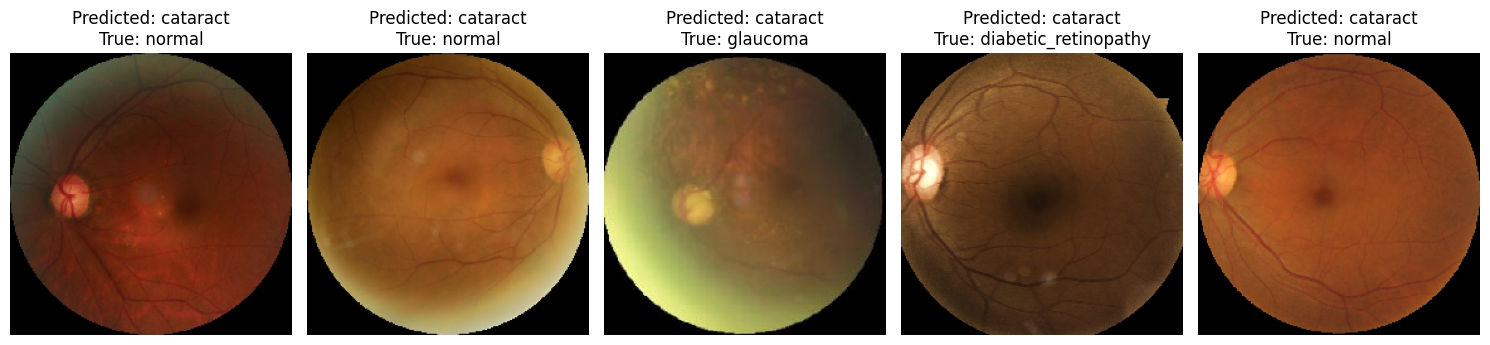

In [73]:
'''
# 获取预测结果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 将真实标签转换为索引
true_classes = np.array([label_to_index[label] for label in test_labels])
'''

index_to_label = {v: k for k, v in label_to_index.items()}


# 找出预测错误的案例
incorrect_indices = np.where(predicted_classes != true_classes)[0]

# 选择要展示的错误案例数量
num_samples_to_show = 5
if len(incorrect_indices) > num_samples_to_show:
    incorrect_indices = np.random.choice(incorrect_indices, num_samples_to_show, replace=False)
# sample_idxs = np.random.choice(misclassified_idxs, num_samples, replace=False)

plt.figure(figsize=(15, 5))
for i, index in enumerate(incorrect_indices):
    img_path = val_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {index_to_label[predicted_classes[index]]}\nTrue: {index_to_label[true_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()



* 展示每张错误分类照片的原始类别概率 (前三高)

In [ ]:
for idx in incorrect_indices:
    original_class_index = true_classes[idx]
    predicted_probs = predictions[idx]

    # 获取前三个最高概率的类别索引
    top_3_indices = np.argsort(predicted_probs)[-3:][::-1]

    print(f"图片索引: {idx}")
    print(f"原始类别: {index_to_label[original_class_index]} (索引: {original_class_index})")
    print("前三个预测概率:")
    for i in top_3_indices:
        print(f"  类别: {index_to_label[i]}, 概率: {predicted_probs[i]:.4f}")
    print("\n")

In [ ]:
import matplotlib.pyplot as plt
import math

# 设置每行显示的图片数量和图像大小
cols = 3
rows = math.ceil(len(incorrect_indices) / cols)
plt.figure(figsize=(cols * 5, rows * 5))

for i, idx in enumerate(incorrect_indices):
    original_class_index = true_classes[idx]
    predicted_probs = predictions[idx]

    # 获取前三个最高概率的类别索引
    top_3_indices = np.argsort(predicted_probs)[-3:][::-1]

    # 加载并显示图片
    img_path = test_image_paths[idx]  # 或 val_image_paths
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # 显示预测结果
    prediction_text = "\n".join([f"{index_to_label[index]}: {predicted_probs[index]:.4f}" for index in top_3_indices])
    plt.title(f"原始类别: {index_to_label[original_class_index]}\n{prediction_text}")

plt.tight_layout()
plt.show()

### 查看特定類別中，被错误分类的案例 (真實為A類中，卻沒有被正確預估回A類的那些照片)

In [ ]:
# 可視化 :

# 定義要查看的類別
specific_label = 'cat'
specific_label_index = label_to_index[specific_label]

'''
# 获取预测结果
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# 将真实标签转换为索引
true_classes = np.array([label_to_index[label] for label in test_labels])
'''

# 找出特定类别中 被错误分类的案例
incorrect_indices = np.where((predicted_classes != true_classes) & (true_classes == specific_label_index))[0]

# 选择要展示的错误案例数量
num_samples_to_show = 5
if len(incorrect_indices) > num_samples_to_show:
    incorrect_indices = np.random.choice(incorrect_indices, num_samples_to_show, replace=False)

# 可视化错误分类的图片
plt.figure(figsize=(15, 5))
for i, index in enumerate(incorrect_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, num_samples_to_show, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {index_to_label[predicted_classes[index]]}\nTrue: {specific_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()

'''
### 全展示
plt.figure(figsize=(15, len(incorrect_indices) * 3))
for i, index in enumerate(incorrect_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(len(incorrect_indices), 1, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {index_to_label[predicted_classes[index]]}\nTrue: {specific_label}")
    plt.axis('off')
plt.tight_layout()
plt.show()
'''

### 查看被錯誤分類類別中，其被错误分类的案例 (預測為B類中，不屬於B類的那些照片的原始類別)

In [ ]:
# 定义被错误分类为的特定类别
misclassified_as_label = 'fish'  # 您关注的被错误分类为的类别
misclassified_as_index = label_to_index[misclassified_as_label]

# 找出被错误分类为特定类别的案例
incorrectly_classified_as_indices = np.where((predicted_classes == misclassified_as_index) & (true_classes != misclassified_as_index))[0]

#
plt.figure(figsize=(15, len(incorrectly_classified_as_indices) * 3))
for i, index in enumerate(incorrectly_classified_as_indices):
    img_path = test_image_paths[index]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(len(incorrectly_classified_as_indices), 1, i + 1)
    plt.imshow(img)
    plt.title(f"Predicted: {misclassified_as_label}\nTrue: {index_to_label[true_classes[index]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

#### 查看所有被预测为特定类别(B類)的图像

In [ ]:
# 定义您想查看的类别
target_label = 'i'  # 请替换 'i' 为您想查看的类别名称
target_index = label_to_index[target_label]  # 获取该类别对应的索引

# 找出所有被预测为该类别的图像索引
predicted_as_target = np.where(predicted_classes == target_index)[0]

# 设置图表大小
plt.figure(figsize=(15, 5))

# 遍历并显示图像
for i, idx in enumerate(predicted_as_target):
    img_path = test_image_paths[idx]
    img = load_img(img_path, target_size=(224, 224))
    plt.subplot(1, len(predicted_as_target), i + 1)
    plt.imshow(img)
    plt.title(f"Predicted as: {target_label}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## 未來，對輸入照片做出預測

### 單張照片

In [ ]:
def predict_single_image(model, img_path, target_size, label_to_index):
    """对单张图片进行预测并返回预测类别。

    Args:
        model: 训练好的模型。
        img_path: 图片的路径。
        target_size: 模型输入尺寸。
        label_to_index: 从类别名称到索引的映射。

    Returns:
        预测的类别名称。
    """
    # 加载图像
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # 归一化
    img = np.expand_dims(img, axis=0)  # 扩展维度以匹配模型输入

    # 预测
    prediction = model.predict(img)
    predicted_class_index = np.argmax(prediction, axis=1)[0]

    # 转换索引回类别名称
    index_to_label = {v: k for k, v in label_to_index.items()}
    predicted_class = index_to_label[predicted_class_index]

    return predicted_class

In [ ]:
img_path = '/path/to/your/image.jpg'  # 替换为您想预测的图片路径
predicted_class = predict_single_image(model, img_path, target_size=(224, 224), label_to_index=label_to_index)
print(f"预测的类别为: {predicted_class}")

*   预处理的必要性 :

    大多数深度学习框架（如 TensorFlow/Keras）期望输入是一个批次（batch）的数据，而不仅仅是单个数据样本。这个“批次”是一个四维数组（或张量），其形状通常是 (batch_size, height, width, channels)。即使您只对单张图像进行预测，也需要将它转换为这种形状的数组。


*   np.expand_dims(img, axis=0) 的作用:

    原始图像数据（例如经过 img_to_array 转换的图像）通常是三维的，形状为 (height, width, channels)。
    
    使用 np.expand_dims(img, axis=0) 后，图像数据的形状变为 (1, height, width, channels)。这里的 1 就是批次大小（batch size），表示这个批次中只有一张图像。

* 給出其前三高的預測的類別名稱及其機率

In [ ]:
def predict_top_3_classes(model, img_path, target_size, label_to_index):
    """对单张图片进行预测并返回前三个预测类别及其概率。

    Args:
        model: 训练好的模型。
        img_path: 图片的路径。
        target_size: 模型输入尺寸。
        label_to_index: 从类别名称到索引的映射。

    Returns:
        一个包含前三个类别名称及其概率的列表及圖片。
    """
    # 加载和预处理图像
    img = load_img(img_path, target_size=target_size)
    img = img_to_array(img) / 255.0  # 归一化
    img = np.expand_dims(img, axis=0)  # 扩展维度以匹配模型输入



    # 预测
    prediction = model.predict(img)[0]

    # 获取前三个最高概率的类别索引
    top_3_indices = np.argsort(prediction)[-3:][::-1]

    # 将索引转换回类别名称，并获取相应的概率
    index_to_label = {v: k for k, v in label_to_index.items()}
    top_3_classes = [(index_to_label[idx], prediction[idx]) for idx in top_3_indices]

    return img, top_3_classes

In [ ]:
img_path = '/path/to/your/image.jpg'  # 替换为您想预测的图片路径
top_3_classes = predict_top_3_classes(model, img_path, target_size=(224, 224), label_to_index=label_to_index)

# 展示图片和预测结果
plt.imshow(img)
plt.axis('off')
prediction_text = "\n".join([f"类别: {label}, 概率: {prob:.4f}" for label, prob in top_3_classes])
plt.title(f"预测结果:\n{prediction_text}")
plt.show()

### 批量照片

In [ ]:
# 一次性顯示完

import matplotlib.pyplot as plt
import math

def predict_images_in_folder_and_show_all(model, folder_path, target_size, label_to_index):
    """遍历文件夹，对所有图片进行预测，并一次性展示所有图片及其预测结果。"""
    filenames = os.listdir(folder_path)
    num_images = len(filenames)
    cols = 3  # 设置每行显示的图片数量
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(cols * 4, rows * 4))  # 调整整体图像大小

    for i, filename in enumerate(filenames):
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        prediction = model.predict(img_array)
        predicted_class_index = np.argmax(prediction, axis=1)[0]
        index_to_label = {v: k for k, v in label_to_index.items()}
        predicted_class = index_to_label[predicted_class_index]

        # 绘制图片及预测结果
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.title(f"{filename}\n预测: {predicted_class}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# 使用函数
folder_path = '/path/to/your/images/folder'
predict_images_in_folder_and_show_all(model, folder_path, target_size=(224, 224), label_to_index=label_to_index)

In [ ]:
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np


# 一張一張顯示
def predict_images_in_folder(model, folder_path, target_size, label_to_index):
    """遍历文件夹并对每张图片进行预测。

    Args:
        model: 训练好的模型。
        folder_path: 包含图片的文件夹的路径。
        target_size: 模型输入尺寸。
        label_to_index: 从类别名称到索引的映射。

    Returns:
        一个包含文件名和预测类别的字典及圖片。
    """
    predictions = {}
    for filename in os.listdir(folder_path):
      # if filename.endswith('.png'):  # 确保是 PNG 图片 (如果有不同檔名再加這個)
        img_path = os.path.join(folder_path, filename)
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img) / 255.0  # 归一化
        img = np.expand_dims(img, axis=0)  # 扩展维度以匹配模型输入

        # 预测
        prediction = model.predict(img)
        predicted_class_index = np.argmax(prediction, axis=1)[0]

        # 转换索引回类别名称
        index_to_label = {v: k for k, v in label_to_index.items()}
        predicted_class = index_to_label[predicted_class_index]

        # 打印预测结果并展示图片
        plt.figure(figsize=(6, 6))
        plt.imshow(img)
        plt.title(f"{filename}\n预测类别: {predicted_class}")
        plt.axis('off')
        plt.show()


# 使用函数
folder_path = '/path/to/your/images/folder'
predictions = predict_images_in_folder(model, folder_path, target_size=(224, 224), label_to_index=label_to_index)


#### 遍历文件夹并对每张图片进行预测，給出其前三的類別名稱及機率 (only 文字)

In [ ]:
def predict_images_in_folder(model, folder_path, target_size, label_to_index):
    """遍历文件夹中的所有图片并打印每张图片的前三个预测类别及其概率。"""
    for filename in os.listdir(folder_path):
        #if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # 支持的图片格式
            img_path = os.path.join(folder_path, filename)
            top_3_classes = predict_top_3_classes(model, img_path, target_size, label_to_index)

            print(f"图片 {filename} 的预测结果:")
            for label, prob in top_3_classes:
                print(f"  类别: {label}, 概率: {prob:.4f}")
            print("\n")

# 使用函数
folder_path = '/path/to/your/images/folder'
predict_images_in_folder(model, folder_path, target_size=(224, 224), label_to_index=label_to_index)

* 遍历文件夹并对每张图片进行预测，給出其前三的類別名稱及機率 (文字+圖片)

In [ ]:
# 一個個顯示
def predict_and_show_images_in_folder(model, folder_path, target_size, label_to_index):
    """遍历文件夹中的所有图片，进行预测并展示结果。"""
    for filename in os.listdir(folder_path):
        #if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(folder_path, filename)
            img, top_3_classes = predict_top_3_classes(model, img_path, target_size, label_to_index)

            # 展示图片和预测结果
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"{filename} 的预测结果:")
            for label, prob in top_3_classes:
                plt.text(0, -10, f"类别: {label}, 概率: {prob:.4f}", fontsize=12)
            plt.show()

# 使用函数
folder_path = '/path/to/your/images/folder'
predict_and_show_images_in_folder(model, folder_path, target_size=(224, 224), label_to_index=label_to_index)

In [ ]:
# 一次性顯示
import matplotlib.pyplot as plt
import math

def predict_and_show_all_images_in_folder(model, folder_path, target_size, label_to_index):
    """遍历文件夹中的所有图片，进行预测并一次性展示所有图片及其预测结果。"""
    filenames = os.listdir(folder_path)
    num_images = len(filenames)
    cols = 3  # 设置每行显示的图片数量
    rows = math.ceil(num_images / cols)  # 计算需要多少行

    plt.figure(figsize=(cols * 4, rows * 4))  # 调整整体图像大小

    for i, filename in enumerate(filenames):
        # if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # 检查文件扩展名
        img_path = os.path.join(folder_path, filename)
        img, top_3_classes = predict_top_3_classes(model, img_path, target_size, label_to_index)

        # 绘制图片及预测结果
        plt.subplot(rows, cols, i + 1)
        plt.imshow(img)
        plt.axis('off')
        prediction_text = "\n".join([f"{label}: {prob:.4f}" for label, prob in top_3_classes])
        plt.title(f"{filename}\n{prediction_text}")

    plt.tight_layout()
    plt.show()

# 使用函数
folder_path = '/path/to/your/images/folder'
predict_and_show_all_images_in_folder(model, folder_path, target_size=(224, 224), label_to_index=label_to_index)